# **Libraries We'll Be Using**

In [0]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, Image, HTML
import h5py

# **Loading SVHN Training and Testing Data  (Format 1: Full-Numbers)**

**Extract Training/Testing images from SVHN train/test.tar.gz files**

In [0]:
def extract_tarball(filename, force=False):
    # Drop the file extension
    root = filename.split('.')[0] 
    
    # If file is already extracted - return
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
        return
    
    # If file is a tarball file - extract it
    if (filename.endswith("tar.gz")):
        print("Extracting %s ..." % filename)
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
        
extract_tarball("test.tar.gz")
extract_tarball("train.tar.gz")

test already present - Skipping extraction of test.tar.gz.
train already present - Skipping extraction of train.tar.gz.


# **Dataset Creation**

**Use Unpacker to get the bounding boxes around the digits in the images**

In [0]:
from unpacker import DigitStructWrapper

def get_bounding_boxes(start_path = '.'):
    """ Extracts a bounding box file and returns a dictionary
    """
    return DigitStructWrapper(start_path).unpack_all()

# Extract the bounding boxes (this will take a while!)
train_bbox = get_bounding_boxes('train/digitStruct.mat')
test_bbox = get_bounding_boxes('test/digitStruct.mat')

# Display the information stored about an individual image
print(json.dumps(train_bbox[0], indent=2))

{
  "filename": "1.png",
  "boxes": [
    {
      "height": 219.0,
      "label": 1.0,
      "left": 246.0,
      "top": 77.0,
      "width": 81.0
    },
    {
      "height": 219.0,
      "label": 9.0,
      "left": 323.0,
      "top": 81.0,
      "width": 96.0
    }
  ]
}


**Show an example image with bounding box**

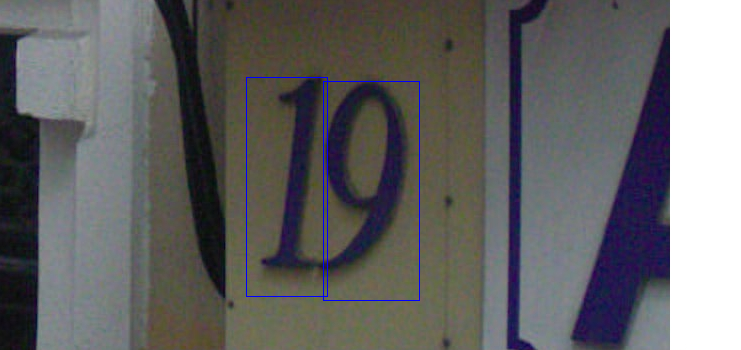

In [0]:
from PIL import Image, ImageDraw

def display_bounding_boxes(img, bounding_boxes):
    """Displays an image and overlays the bounding boxes
    """
    # Opens and identifies the given image file
    image = Image.open(img)
    
    # Use draw module can be used to annotate the image
    draw = ImageDraw.Draw(image)
    
    for b in bounding_boxes:
        
        # Bounding box rectangle [x0, y0, x1, y1]
        rectangle = [b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']]
        
        # Draw a rectangle on top of the image
        draw.rectangle(rectangle, outline="blue")
        
    # Return altered image    
    return image


# Select an image and the corresponding boxes
image = 'train/1.png'
image_bounding_boxes = train_bbox[0]['boxes']
     
# Display image with bounding boxes
display_bounding_boxes(image, image_bounding_boxes)

**Create a Pandas dataframe of the image data**

In [0]:
def dict_to_dataframe(image_bounding_boxes, path):
    """ Helper function for flattening the bounding box dictionary
    """
    # Store each bounding box
    boxes = []
    
    # For each set of bounding boxes
    for image in image_bounding_boxes:
        
        # For every bounding box
        for bbox in image['boxes']:
            
            # Store a dict with the file and bounding box info
            boxes.append({
                    'filename': path + image['filename'],
                    'label': bbox['label'],
                    'width': bbox['width'],
                    'height': bbox['height'],
                    'top': bbox['top'],
                    'left': bbox['left']})
            
    # return the data as a DataFrame
    return pd.DataFrame(boxes)


# We store the bounding boxes here
bbox_file = 'bounding_boxes.csv'

if not os.path.isfile(bbox_file):
    
    # Extract every individual bounding box as DataFrame  
    train_df = dict_to_dataframe(train_bbox, 'train/')
    test_df = dict_to_dataframe(test_bbox, 'test/')

    print("Training", train_df.shape)
    print("Test", test_df.shape)
    print('')

    # Concatenate all the information in a single file
    df = pd.concat([train_df, test_df])
    
    print("Combined", df.shape)

    # Write dataframe to csv
    df.to_csv(bbox_file, index=False)

    # Delete the old dataframes
    del train_df, test_df, train_bbox, test_bbox
    
else:
    # Load preprocessed bounding boxes
    df = pd.read_csv(bbox_file)

# Display the first 10 rows of dataframe
df.head()

,filename,height,label,left,top,width
0,train/1.png,219.0,1.0,246.0,77.0,81.0
1,train/1.png,219.0,9.0,323.0,81.0,96.0
2,train/2.png,32.0,2.0,77.0,29.0,23.0
3,train/2.png,32.0,3.0,98.0,25.0,26.0
4,train/3.png,15.0,2.0,17.0,5.0,8.0


**Group images and draw a single bounding box around all the digits**

In [0]:

# Rename the columns to more suitable names
df.rename(columns={'left': 'x0', 'top': 'y0'}, inplace=True)

# Calculate x1 and y1
df['x1'] = df['x0'] + df['width']
df['y1'] = df['y0'] + df['height']

# Perform the following aggregations
aggregate = {'x0':'min',
             'y0':'min',
             'x1':'max',
             'y1':'max',
             'label':{
                'labels': lambda x: list(x),
                'num_digits': 'count'}}

# Apply the aggration
df = df.groupby('filename').agg(aggregate).reset_index()

# Fix the column names after aggregation
df.columns = [x[0] if i < 5 else x[1] for i, x in enumerate(df.columns.values)]

# Display the results
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,filename,x0,y0,x1,y1,labels,num_digits
0,test/1.png,43.0,7.0,62.0,37.0,[5.0],1
1,test/10.png,16.0,19.0,38.0,40.0,"[1.0, 6.0]",2
2,test/100.png,124.0,65.0,152.0,99.0,"[6.0, 1.0]",2
3,test/1000.png,210.0,59.0,245.0,87.0,"[2.0, 7.0]",2
4,test/10000.png,35.0,11.0,66.0,32.0,"[1.0, 4.0, 3.0]",3


Display image again to make sure everything looks fine

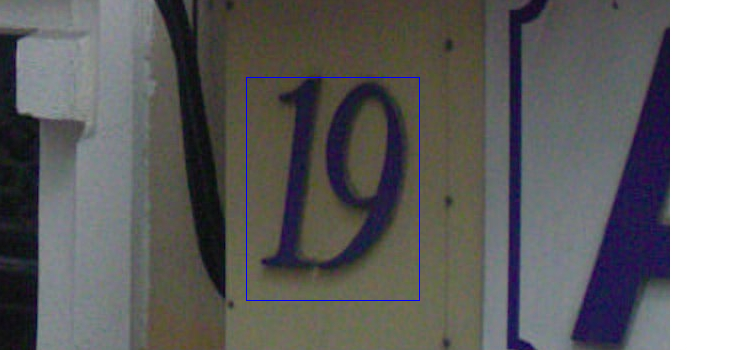

In [0]:
from PIL import Image, ImageDraw

def display_bbox(image_path, bbox):
    """ Helper function to display a single image and bounding box
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    draw.rectangle([bbox['x0'], bbox['y0'], bbox['x1'], bbox['y1']], outline="blue")
    return image


# Select a image and bounding box
image = 'train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

Expand the bounding box around the digits

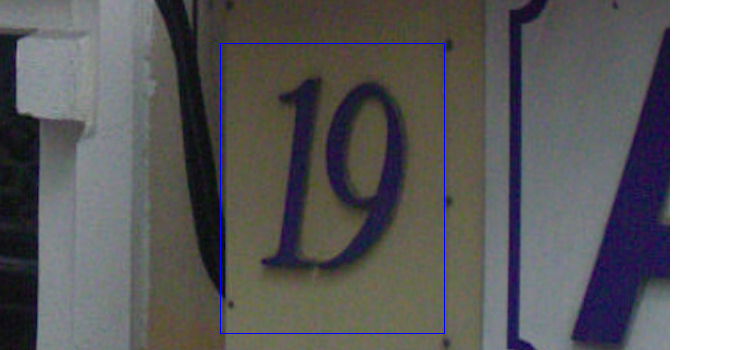

In [0]:

# Calculate the increase in both directions
df['x_increase'] = ((df['x1'] - df['x0']) * 0.3) / 2.
df['y_increase'] = ((df['y1'] - df['y0']) * 0.3) / 2.

# Apply the increase in all four directions
df['x0'] = (df['x0'] - df['x_increase']).astype('int')
df['y0'] = (df['y0'] - df['y_increase']).astype('int')
df['x1'] = (df['x1'] + df['x_increase']).astype('int')
df['y1'] = (df['y1'] + df['y_increase']).astype('int')


# Select the dataframe row corresponding to our image
image = 'train/1.png'
bbox = df[df.filename == image]

# Display image
display_bbox(image, bbox)

**Collect Image size and width information**

In [0]:
def get_image_size(filepath):
    """Returns the image size in pixels given as a 2-tuple (width, height)
    """
    image = Image.open(filepath)
    return image.size 

def get_image_sizes(folder):
    """Returns a DataFrame with the file name and size of all images contained in a folder
    """
    image_sizes = []
    
    # Get all .png images contained in the folder
    images = [img for img in os.listdir(folder) if img.endswith('.png')]
    
    # Get image size of every individual image
    for image in images:
        w, h = get_image_size(folder + image)
        image_size = {'filename': folder + image, 'image_width': w, 'image_height': h}
        image_sizes.append(image_size)
        
    # Return results as a pandas DataFrame
    return pd.DataFrame(image_sizes)


# Extract the image sizes
train_sizes = get_image_sizes('train/')
test_sizes = get_image_sizes('test/')

# Concatenate all the information in a single file
image_sizes = pd.concat([train_sizes, test_sizes])

# Delete old dataframes
del train_sizes, test_sizes

# Display 10 image sizes
image_sizes.head(10)

,filename,image_height,image_width
0,train/12134.png,70,180
1,train/14606.png,23,43
2,train/9100.png,54,108
3,train/18335.png,23,52
4,train/29660.png,40,93
5,train/1505.png,25,49
6,train/28355.png,201,351
7,train/11612.png,31,68
8,train/31626.png,40,87
9,train/12000.png,33,76


**Merge image bounding box data with image size data**

In [0]:

print("Bounding boxes", df.shape)
print("Image sizes", image_sizes.shape)
print('')

# Inner join the datasets on filename
df = pd.merge(df, image_sizes, on='filename', how='inner')

print("Combined", df.shape)

# Delete the image size df
del image_sizes

# Store checkpoint
df.to_csv("image_data.csv", index=False)
#df = pd.read_csv('data/image_data.csv')

df.head()

Bounding boxes (46470, 9)
Image sizes (46470, 3)

Combined (46470, 11)


,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_height,image_width
0,test/1.png,40,2,64,41,[5.0],1,2.85,4.50,47,99
1,test/10.png,12,15,41,43,"[1.0, 6.0]",2,3.30,3.15,55,87
2,test/100.png,119,59,156,104,"[6.0, 1.0]",2,4.20,5.10,133,353
3,test/1000.png,204,54,250,91,"[2.0, 7.0]",2,5.25,4.20,239,625
4,test/10000.png,30,7,70,35,"[1.0, 4.0, 3.0]",3,4.65,3.15,42,171


**Bounding box correction (makes sure there are no clipped digits)**

In [0]:

# Correct bounding boxes not contained by image
df.loc[df['x0'] < 0, 'x0'] = 0
df.loc[df['y0'] < 0, 'y0'] = 0
df.loc[df['x1'] > df['image_width'], 'x1'] = df['image_width']
df.loc[df['y1'] > df['image_height'], 'y1'] = df['image_width']

df.head()

,filename,x0,y0,x1,y1,labels,num_digits,x_increase,y_increase,image_height,image_width
0,test/1.png,40,2,64,41,[5.0],1,2.85,4.50,47,99
1,test/10.png,12,15,41,43,"[1.0, 6.0]",2,3.30,3.15,55,87
2,test/100.png,119,59,156,104,"[6.0, 1.0]",2,4.20,5.10,133,353
3,test/1000.png,204,54,250,91,"[2.0, 7.0]",2,5.25,4.20,239,625
4,test/10000.png,30,7,70,35,"[1.0, 4.0, 3.0]",3,4.65,3.15,42,171


Remove entries with < 5 digits in the sequence

In [0]:
# Keep only images with less than 6 digits
df = df[df.num_digits < 6]
df[['image_width', 'image_height']].describe().round(decimals=2)

,image_width,image_height
count,46469.00,46469.00
mean,140.74,61.25
std,96.36,42.01
min,25.00,12.00
25%,78.00,34.00
50%,111.00,49.00
75%,171.00,75.00
max,1083.00,516.00


**Crop and reshape images**

In [0]:
from scipy.ndimage import imread
from scipy.misc import imresize

def crop_and_resize(image, img_size):
    """ Crop and resize an image
    """
    image_data = imread(image['filename'])
    crop = image_data[image['y0']:image['y1'], image['x0']:image['x1'], :]
    return imresize(crop, img_size)


def create_dataset(df, img_size):
    """ Helper function for converting images into a numpy array
    """
    # Initialize the numpy arrays (0's are stored as 10's)
    X = np.zeros(shape=(df.shape[0], img_size[0], img_size[0], 3), dtype='uint8')
    y = np.full((df.shape[0], 5), 10, dtype=int)
    
    # Iterate over all images in the pandas dataframe (slow!)
    for i, (index, image) in enumerate(df.iterrows()):
        
        # Get the image data
        X[i] = crop_and_resize(image, img_size)
        
        # Get the label list as an array
        labels = np.array((image['labels']))
                
        # Store 0's as 0 (not 10)
        labels[labels==10] = 0
        
        # Embed labels into label array
        y[i,0:labels.shape[0]] = labels
        
    # Return data and labels   
    return X, y


# Change this to select a different image size
image_size = (32, 32)

# Get cropped images and labels (this might take a while...)
X_train, y_train = create_dataset(df[df.filename.str.contains('train')], image_size)
X_test, y_test = create_dataset(df[df.filename.str.contains('test')], image_size)

# We no longer need the dataframe
del df

print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Training (33401, 32, 32, 3) (33401, 5)
Test (13068, 32, 32, 3) (13068, 5)


**Plot some example images**

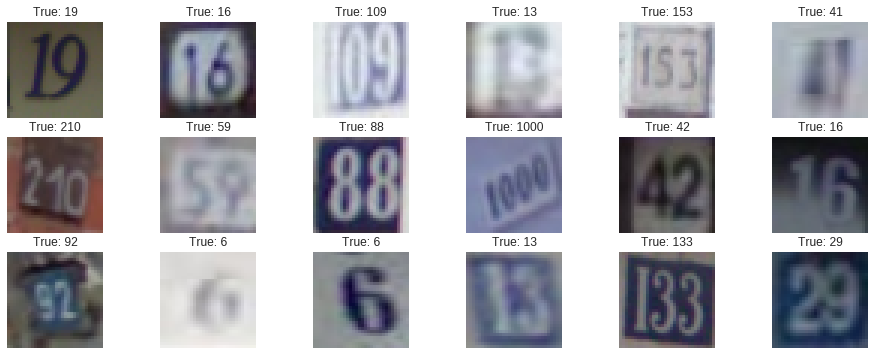

In [0]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "True: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "True: {0}, Pred: {1}".format(true_number, pred_number)  
        ax.imshow(images[i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
        
        
# Display images from the training set
plot_images(X_train, 3, 6, y_train);

# **Data Preprocessing**

**Create a validation set**

In [0]:
from sklearn.model_selection import train_test_split

# create a validation set from the training set
# currently using an 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# check that the shapes of the sets are fine
print("Training X: ", X_train.shape)
print("Training Y: ", y_train.shape)
print('Validation X', X_val.shape)
print('Validation Y', y_val.shape)

Training X:  (26720, 32, 32, 3)
Training Y:  (26720, 5)
Validation X (6681, 32, 32, 3)
Validation Y (6681, 5)


**Perform preprocessing (grayscaling and normalization)**

In [0]:
# helper function to convert image arrays from rgb to grayscale
# can convert from RGB to grayscale using the function: 
# Y = (0.299 * R) + (0.587 * G) + (0.114 * B)
def gray_conv(img):
  r = 0.299
  g = 0.587
  b = 0.114
  grayscale_img = np.expand_dims(np.dot(img, [r,g,b]), axis = 3)
  return grayscale_img


# convert to grayscale
X_train = gray_conv(X_train).astype(np.float32)
X_test = gray_conv(X_test).astype(np.float32)
X_val = gray_conv(X_val).astype(np.float32)


# normalize the grayscale datasets

# get the mean and standard deviation from the training set
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# perform the normalization
X_train = (X_train - mean) / std
X_test = (X_test - mean)  / std
X_val = (X_val - mean) / std

# **Export Preprocessed Data**

In [0]:
# make the file
h5f = h5py.File('SVHN_Preprocessed_Multi.h5', 'w')

# store training, testing, and validation sets
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=X_test)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('y_val', data=y_val)

# close the file
h5f.close()